
---

**Import the necessary libraries.**

---

In [65]:
# Required Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd  # For loading and processing data
import re  # For regex-based text cleaning
from nltk.corpus import stopwords  # For removing stopwords
from nltk.stem import WordNetLemmatizer  # For lemmatization
from sklearn.model_selection import train_test_split # For train-test split 
from sklearn.feature_extraction.text import TfidfVectorizer #transforms the text data into numerical features (using TF-IDF)

# Make sure to download the necessary NLTK resources 
import nltk
nltk.download('stopwords')  # Download stopwords
nltk.download('wordnet')  # Download WordNet for lemmatizer



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\magda\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\magda\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

---

**Load the datasets.**

---


In [30]:
# url of train labeled dataset
url_labeled_data = 'https://raw.githubusercontent.com/LefkiAth/Semeval2025/refs/heads/main/data/labeled_trial-training_data(5028samples).csv'
# load training data
train_data = pd.read_csv(url_labeled_data)

# url of unlabeled test set
url_testset = 'https://raw.githubusercontent.com/LefkiAth/Semeval2025/refs/heads/main/data/unlabeled_test_data(997).csv'
# load the test data
test_data = pd.read_csv(url_testset)


# url of unlabeled validation set
url_validation_set = 'https://raw.githubusercontent.com/LefkiAth/Semeval2025/refs/heads/main/data/unlabeled_validation_data(565).csv'
# load the validation data
validation_data = pd.read_csv(url_validation_set)

train_data.head()

,Unnamed: 0,year,month,day,country,title,text,hazard-category,product-category,hazard,product
0,0,1994,1,7,us,Recall Notification: FSIS-024-94,Case Number: 024-94 \n Date Opene...,biological,"meat, egg and dairy products",listeria monocytogenes,smoked sausage
1,1,1994,3,10,us,Recall Notification: FSIS-033-94,Case Number: 033-94 \n Date Opene...,biological,"meat, egg and dairy products",listeria spp,sausage
2,2,1994,3,28,us,Recall Notification: FSIS-014-94,Case Number: 014-94 \n Date Opene...,biological,"meat, egg and dairy products",listeria monocytogenes,ham slices
3,3,1994,4,3,us,Recall Notification: FSIS-009-94,Case Number: 009-94 \n Date Opene...,foreign bodies,"meat, egg and dairy products",plastic fragment,thermal processed pork meat
4,4,1994,7,1,us,Recall Notification: FSIS-001-94,Case Number: 001-94 \n Date Opene...,foreign bodies,"meat, egg and dairy products",plastic fragment,chicken breast


To prepare the text data for further analysis or model training, we first clean the text. This includes several preprocessing steps like converting the text to lowercase, removing special characters and numbers, and lemmatizing the words. Additionally, we remove common stopwords (like "the", "is", "and", etc.) that do not add significant meaning for the task at hand.

* First, we initialize the **stopwords** and **lemmatizer**. The stopwords are a list of commonly used words in English that are not useful in the text classification task. The lemmatizer will reduce words to their base form, making it easier for the model to recognize similar words.
* We then define a function, clean_text, that performs the following operations:
    * Lowercasing: Converts all text to lowercase, ensuring that same words are treated the same.
    * Removing Special Characters: Using a regular expression, it removes any non-alphanumeric characters (like punctuation marks).
    * Removing Numbers: Another regular expression removes any numerical values that might not be relevant for the text classification task.
    * Stopwords Removal and Lemmatization: For each word in the text, we check if it is a stopword and if not, we apply lemmatization to reduce it to its base form.
* Finally, we apply this cleaning function to the 'title' column of the dataset.

In [34]:
# Drop unnecessary columns
# This removes any columns that are not required for analysis or modeling, such as 'Unnamed: 0'.
columns_to_drop = ['Unnamed: 0']
train_data_cleaned = train_data.drop(columns=columns_to_drop)

# Initialize Stopwords and Lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Function that cleans the text
def clean_text(text):
    text = text.lower() # Convert words to lowercase
    text = re.sub(r'[^\w\s]', ' ', text)  # Remove special characters
    text = re.sub(r'\d+', ' ', text)      # Remove numbers
    words = text.split()
    # if word not a stopword, processed by lemmatizer
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

# Add a cleaned_text column with the cleaned title
train_data['cleaned_title'] = train_data['title'].apply(clean_text)


---

**Train-Test Split for Hazard-Category, Product-Category, and Product**

---

This section covers the process of performing train-test splits on various columns, including hazard-category, product-category, and product, ensuring balanced data for training and evaluation.

1. **Hazard-Category Split:**
We begin by splitting the dataset based on the hazard-category column. Stratified sampling ensures that both the training and test sets maintain the same distribution of hazard categories as the original dataset. This prevents underrepresentation of any category, which is crucial for accurate model evaluation.
    - Stratification: Ensures equal distribution of hazard categories in both sets.
2. **Product-Category Split:**
Next, we split the dataset based on the product-category column. Similar to hazard categories, stratification is used to ensure proportional representation of each product category in the training and test sets.
    - Why this split?: To maintain a balanced distribution of product categories in both sets.
3. **Handling Rare Classes in the Product Column:**
The product column contains categories with very few samples. These rare categories can distort model performance. To address this, we group rare classes (with fewer than 5 samples) into an "Other" category, and then apply stratification.
Threshold for Rare Classes: Classes with fewer than 5 samples are grouped as "Other".
    - Stratification: Ensures the "Other" category is proportionally represented in both sets.
4. **Final Hazard Split:**
We perform a final train-test split based on the hazard column. Stratification ensures that both the training and test sets have balanced hazard types, preventing any specific hazard from being underrepresented.
5. **Checking the Size of the Splits:**
We check the sizes of the resulting training and test sets for each column to confirm that the splits were applied correctly.

This process ensures that each dataset (hazard-category, product-category, product, hazard) is properly balanced, allowing for fair model evaluation and preventing biases caused by imbalanced data distributions.

In [42]:
# Train-test split for hazard-category
train_set_hazard_category, test_set_hazard_category = train_test_split(
    train_data, 
    test_size=0.2, 
    random_state=42, 
    stratify=train_data['hazard-category']
)

# Train-test split for product-category
train_set_product_category, test_set_product_category = train_test_split(
    train_data, 
    test_size=0.2, 
    random_state=42, 
    stratify=train_data['product-category']
)


# Define a threshold for rare classes (e.g., classes with less than 5 samples)
threshold = 5

# Identify the classes that have fewer than the threshold number of samples
rare_classes = train_data['product'].value_counts()[train_data['product'].value_counts() < threshold].index

# Replace rare classes with 'Other'
train_data['product'] = train_data['product'].apply(lambda x: 'Other' if x in rare_classes else x)

# Now perform the train-test split with stratification
train_set_product, test_set_product = train_test_split(
    train_data, 
    test_size=0.2, 
    random_state=42, 
    stratify=train_data['product']
)


# Train-test split for hazard (final split)
train_set_hazard, test_set_hazard = train_test_split(
    train_data, 
    test_size=0.2, 
    random_state=42, 
    stratify=train_data['hazard']
)



# Check the size of both the training and test sets for hazard
print("Hazard Split:", train_set_hazard.shape, test_set_hazard.shape)

# Check the size of both the training and test sets
print("Product Split:", train_set_product.shape, test_set_product.shape)

# Check the size of both the training and test sets for product-category
print("Product-Category Split:", train_set_product_category.shape, test_set_product_category.shape)

# Check the size of both the training and test sets for hazard-category
print("Hazard-Category Split:", train_set_hazard_category.shape, test_set_hazard_category.shape)


Hazard Split: (4065, 12) (1017, 12)
Product Split: (4065, 12) (1017, 12)
Product-Category Split: (4065, 12) (1017, 12)
Hazard-Category Split: (4065, 12) (1017, 12)


---

Merging and Cleaning the Train and Test Sets

---



In this step, we combine the individual train and test sets for the hazard-category, product-category, product, and hazard columns into unified datasets. This ensures that all relevant features are included for model training and evaluation.

**Combining the Training and Test Sets:** We merge the different splits to create comprehensive training and testing datasets that include all necessary features for the model.

**Removing Duplicates:** After combining the datasets, we remove any duplicate rows to ensure that no sample is overrepresented, preventing bias in training and evaluation.

**Verifying the Size:** We check the size of the combined datasets to confirm that the merging process has been successful and that we have the right amount of data for model development.

By performing these steps, we ensure that the datasets are clean, balanced, and ready for further analysis or modeling.



In [46]:
# Merge all the train and test sets for each column

# Combine train sets for all the splits
train_set = pd.concat([train_set_hazard_category, train_set_product_category, train_set_product, train_set_hazard])

# Combine test sets for all the splits
test_set = pd.concat([test_set_hazard_category, test_set_product_category, test_set_product, test_set_hazard])

# Check if there are any duplicates in the combined train and test sets
train_set = train_set.drop_duplicates()
test_set = test_set.drop_duplicates()

# Check the size of the combined train and test sets
print("Combined Train Set Size:", train_set.shape)
print("Combined Test Set Size:", test_set.shape)


Combined Train Set Size: (5070, 12)
Combined Test Set Size: (2992, 12)


---

Feature and Label Extraction

---

Then, we extract input features and target labels for both short and long text analysis tasks. First, we extract the "cleaned_title" feature for short text analysis from both the training and test sets. Then, for **Subtask 1 (ST1)**, we assign the target labels for **hazard-category** and **product-category**. For **Subtask 2 (ST2)**, we assign labels for **hazard** and **product** vectors. After extracting the features and labels, we confirm the shape of both training and test datasets to ensure the correct data structure before proceeding to model training and evaluation.

In [ ]:
# 1. Extract input features and labels for Short Text

# Features for short text analysis
X_train_title = train_set["cleaned_title"]
X_test_title = test_set["cleaned_title"]

# 2. Target labels for Subtask 1 (ST1)
# Target labels for hazard-category and product-category
y_train_hazard_category = train_set["hazard-category"]
y_test_hazard_category = test_set["hazard-category"]
y_train_product_category = train_set["product-category"]
y_test_product_category = test_set["product-category"]

# 3. Target labels for Subtask 2 (ST2)
# Target labels for hazard and product vectors
y_train_hazard_vector = train_set["hazard"]
y_test_hazard_vector = test_set["hazard"]
y_train_product_vector = train_set["product"]
y_test_product_vector = test_set["product"]


# 4. Confirm the extracted features and labels

# Check the shape of the extracted features and labels for the training set
print("Training Set Features (Title):", X_train_title.shape)
print("Training Set Labels (Hazard Category):", y_train_hazard_category.shape)
print("Training Set Labels (Product Category):", y_train_product_category.shape)
print("Training Set Labels (Hazard Vector):", y_train_hazard_vector.shape)
print("Training Set Labels (Product Vector):", y_train_product_vector.shape)

# Check the shape of the extracted features and labels for the test set
print("\nTest Set Features (Title):", X_test_title.shape)
print("Test Set Labels (Hazard Category):", y_test_hazard_category.shape)
print("Test Set Labels (Product Category):", y_test_product_category.shape)
print("Test Set Labels (Hazard Vector):", y_test_hazard_vector.shape)
print("Test Set Labels (Product Vector):", y_test_product_vector.shape)



Training Set Features (Title): (5070,)
Training Set Labels (Hazard Category): (5070,)
Training Set Labels (Product Category): (5070,)
Training Set Labels (Hazard Vector): (5070,)
Training Set Labels (Product Vector): (5070,)

Test Set Features (Title): (2992,)
Test Set Labels (Hazard Category): (2992,)
Test Set Labels (Product Category): (2992,)
Test Set Labels (Hazard Vector): (2992,)
Test Set Labels (Product Vector): (2992,)


---

TF-IDF Vectorization

---

This step uses **TF-IDF (Term Frequency-Inverse Document Frequency)** to vectorize the short text data ("title"). The **TfidfVectorizer** is configured to extract up to 5000 features and consider unigrams and bigrams. The `fit_transform` method is applied to the training data, and `transform` is used for the test data. The shape of the resulting TF-IDF matrix for the training set is then displayed, preparing the text data for machine learning models.

In [74]:
# Vectorize the text data using TF-IDF for titles (short text) 
tfidf_title = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

# Fit-transform on training data and transform on test data for titles
X_train_title_tfidf = tfidf_title.fit_transform(X_train_title)
X_test_title_tfidf = tfidf_title.transform(X_test_title)

# Confirm the shape of the transformed features
X_train_title_tfidf.shape

(5070, 5000)

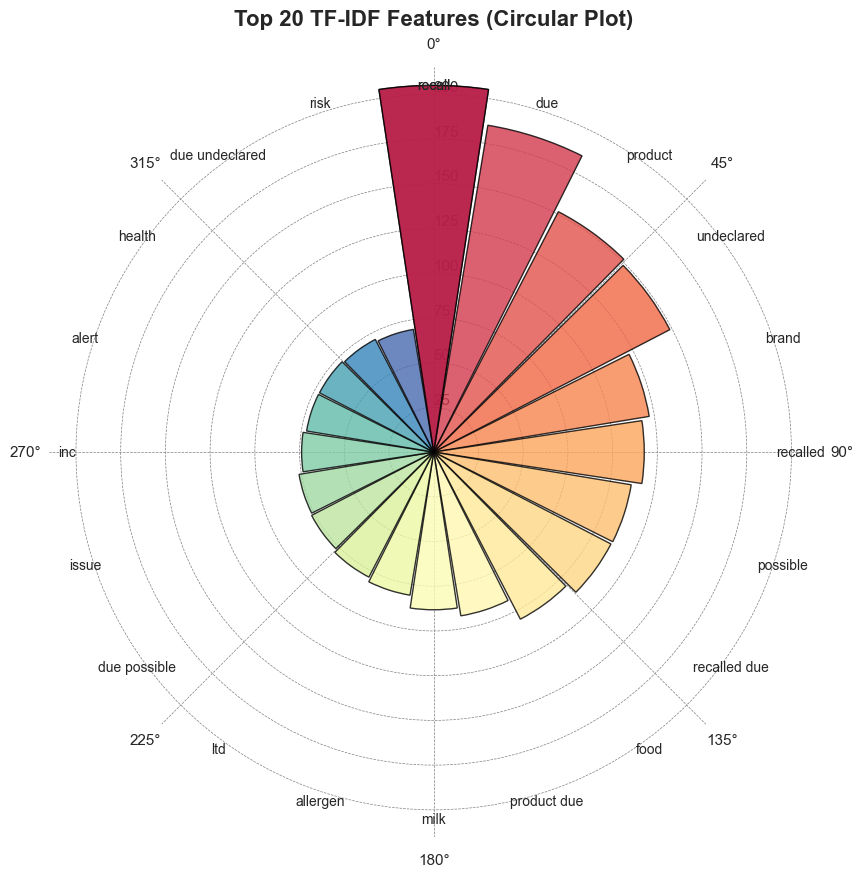

In [99]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sort the top features by their scores in descending order
sorted_top_features = sorted(top_features, key=lambda x: x[1], reverse=True)
features, scores = zip(*sorted_top_features)

# Convert `scores` to a list before concatenation
scores = list(scores)
features = list(features)

# Define the number of bars and angles for the circular plot
num_bars = len(features)
angles = np.linspace(0, 2 * np.pi, num_bars, endpoint=False).tolist()

# Extend the angles and features to complete the circle
angles += angles[:1]  # Complete the circle for the angles
scores += scores[:1]  # Complete the circle for the scores
features += features[:1]  # Complete the circle for the features

# Create the polar plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': 'polar'})

# Use a different color palette (e.g., 'Spectral' for better contrast)
bars = ax.bar(angles, scores, color=sns.color_palette("Spectral", num_bars), width=0.3, align='center', alpha=0.8, edgecolor='black')

# Add feature names as labels around the circle, ensuring uniform direction
for angle, feature in zip(angles, features):
    ax.text(
        angle, max(scores) + 0.1, feature, 
        ha='center', va='center', rotation=0, fontsize=10
    )

# Enhance aesthetics
ax.set_theta_offset(np.pi / 2)  # Rotate the plot
ax.set_theta_direction(-1)  # Reverse the direction
ax.set_rlabel_position(0)  # Move radial labels
ax.spines['polar'].set_visible(False)  # Hide frame
ax.grid(color='gray', linestyle='--', linewidth=0.5)

# Add title with padding and styling
ax.set_title('Top 20 TF-IDF Features (Circular Plot)', fontsize=16, weight='bold', pad=30)

plt.show()
